# Imports

In [1]:
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torchvision import datasets, models
from torchvision.transforms import v2

In [2]:
torch.set_float32_matmul_precision('high')

# Hyperparameters

In [3]:
batch_size = 32

# Data Loading

In [4]:
train_transform = v2.Compose([
    v2.RandomRotation(30),
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop(256, scale=(0.5, 1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform = v2.Compose([
    v2.Resize((256,256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load data from PetImages folder
traindata = datasets.ImageFolder('catvdog_small/train', transform=train_transform)
valdata = datasets.ImageFolder('catvdog_small/validation', transform=test_transform)
testdata = datasets.ImageFolder('catvdog_small/test', transform=test_transform)

In [5]:
trainloader = torch.utils.data.DataLoader(
    traindata, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
valloader = torch.utils.data.DataLoader(
    valdata, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
testloader = torch.utils.data.DataLoader(
    testdata, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# Model creation

I'll use a resnet model. It is accurate on ImageNet and is broken up into layers that can be easily unfrozen and trained.

In [6]:
models.resnet152()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
class ResNet(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.resnet = models.resnet152(weights='DEFAULT')
        self.train_acc = Accuracy(task='multiclass', num_classes=2)
        self.val_acc = Accuracy(task='multiclass', num_classes=2)
        self.test_acc = Accuracy(task='multiclass', num_classes=2)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features, 2)
        )
        self._freeze()
        self.unfreeze(layer='fc')

    def _freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

    def unfreeze(self, layer):
        for name, param in self.resnet.named_parameters():
            if layer in name:
                param.requires_grad = True

    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.test_acc(y_hat, y)
        self.log('test_acc', acc)
        return acc
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Model training

Starting with only the fully connected layer unfrozen.

In [26]:
model = ResNet()

trainer1 = L.Trainer(
    callbacks=[
        L.pytorch.callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='max'),
        L.pytorch.callbacks.ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')
    ]
)
trainer1.fit(model, trainloader, valloader)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/chandon/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:21<00:00, 11.1MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/chandon/miniconda3/envs/pyto/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 62.3 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
4.2 M     Trainable params
58.1 M    Non-trainable params


Epoch 4: 100%|██████████| 63/63 [00:08<00:00,  7.29it/s, v_num=23, train_acc_step=0.875, val_acc=0.983, train_acc_epoch=0.975]


Unfreezing the last convolutional block of layers.

In [27]:
model = ResNet.load_from_checkpoint(trainer1.checkpoint_callback.best_model_path)
model.unfreeze(layer='layer4')
model.lr = 1e-4
trainer2 = L.Trainer(
    callbacks=[
        L.pytorch.callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='max'),
        L.pytorch.callbacks.ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')
    ]
)
trainer2.fit(model, trainloader, valloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 62.3 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
19.2 M    Trainable params
43.2 M    Non-trainable params
62.3 M    Total params
249.377   Total estimated model params size (MB)
430       Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s, v_num=24, train_acc_step=1.000, val_acc=0.986, train_acc_epoch=0.998]


One more time of unfreezing the next convolutional block of layers.

In [28]:
model = ResNet.load_from_checkpoint(trainer2.checkpoint_callback.best_model_path)
model.unfreeze(layer='layer3')
model.lr = 1e-5
trainer3 = L.Trainer(
    callbacks=[
        L.pytorch.callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='max'),
        L.pytorch.callbacks.ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')
    ]
)
trainer3.fit(model, trainloader, valloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 62.3 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
44.8 M    Trainable params
17.5 M    Non-trainable params
62.3 M    Total params
249.377   Total estimated model params size (MB)
430       Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s, v_num=25, train_acc_step=1.000, val_acc=0.992, train_acc_epoch=0.998]


# Model testing

In [8]:
model = ResNet.load_from_checkpoint('lightning_logs/version_25/checkpoints/epoch=1-step=126.ckpt')

In [9]:
test_trainer = L.Trainer()
test_trainer.test(model, testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/chandon/miniconda3/envs/pyto/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9940000176429749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9940000176429749}]

I'd say that's pretty decent.

In [10]:
# Find mislabelled test images
predictions = test_trainer.predict(model, testloader)
predictions = torch.argmax(torch.cat(predictions), dim=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]


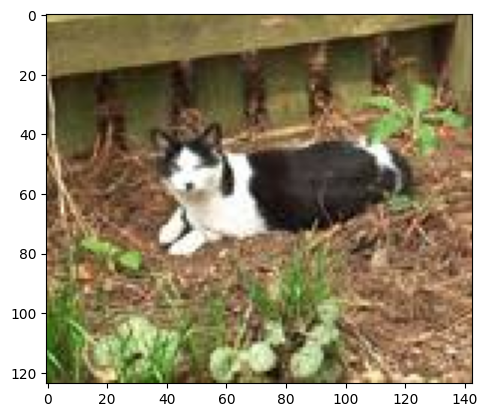

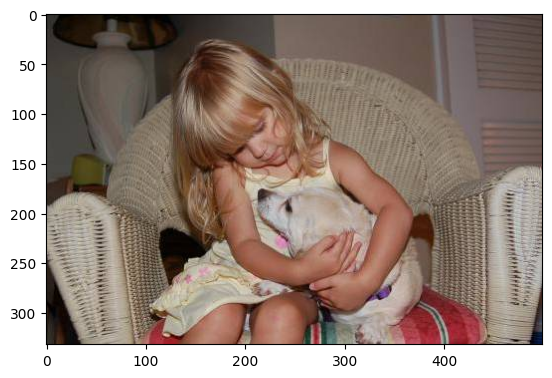

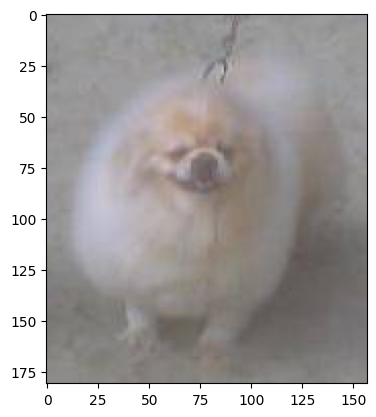

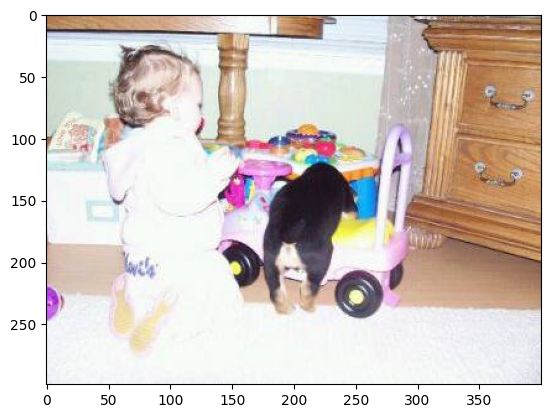

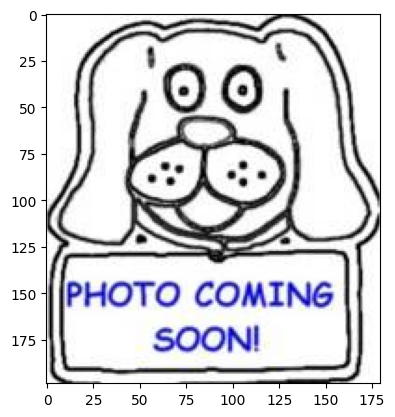

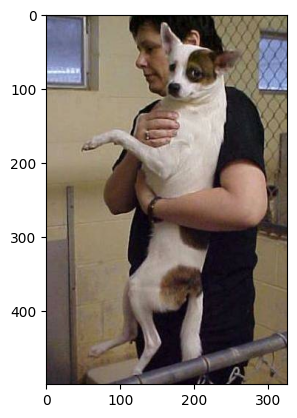

In [11]:
mislabeled = torch.tensor(testloader.dataset.targets) != predictions
mislabeled_indices = torch.arange(len(testloader.dataset))[mislabeled]
for idx in mislabeled_indices:
    plt.imshow(datasets.ImageFolder('catvdog_small/test')[idx][0])
    plt.show()

These mistakes are understandable. I think there are a lot more samples of humans holding cats in the training data and the other images are blurry or ambiguous.

There's a big version to this dataset I found on kaggle. What kind of accuracy can the model get on that data?

In [12]:
big_testdata = datasets.ImageFolder('PetImages', transform=test_transform)
big_testloader = torch.utils.data.DataLoader(
    big_testdata, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
test_trainer.test(model, big_testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:  95%|█████████▍| 740/782 [00:59<00:03, 12.36it/s]

/home/chandon/miniconda3/envs/pyto/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Testing DataLoader 0: 100%|██████████| 782/782 [01:03<00:00, 12.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9929594397544861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9929594397544861}]

Not bad, not bad at all. I wonder what kind of accuracy could have been achieved if I had trained with more data. 